In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ---------- Load CSV ----------
csv_path = "/Users/sanazkazeminia/Documents/mol_test_suite/data/similarity_experiments/sucos_sim/sucos_comparison_7e2z_diffsbdd_prism.csv"
df = pd.read_csv(csv_path)

df.head()


,set,idx,sucos,features,shape
0,PRISM,0,0.448138,0.310597,0.585678
1,PRISM,1,0.410683,0.243398,0.577968
2,PRISM,2,0.327491,0.124086,0.530895
3,PRISM,3,0.355459,0.188133,0.522784
4,PRISM,4,0.346400,0.113845,0.578954


In [2]:
# ---------- Helper functions ----------

def _as_clean_array(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x)]

def cliffs_delta(x, y):
    """
    Cliff's delta: P(X>Y) - P(X<Y).
    Thresholds: |δ| ~0.147 (small), 0.33 (medium), 0.474 (large).
    """
    x = _as_clean_array(x)
    y = _as_clean_array(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    if nx * ny <= 100_000:
        diff = x[:, None] - y[None, :]
        return (np.sum(diff > 0) - np.sum(diff < 0)) / (nx * ny)
    rng = np.random.default_rng(123)
    xs = rng.choice(x, size=min(nx, 500), replace=False)
    ys = rng.choice(y, size=min(ny, 500), replace=False)
    diff = xs[:, None] - ys[None, :]
    return (np.sum(diff > 0) - np.sum(diff < 0)) / (xs.size * ys.size)

def run_stats(x, y, label):
    print(f"\n=== {label}: PRISM vs DiffSBDD ===")
    x = _as_clean_array(x)
    y = _as_clean_array(y)
    print(f"n_PRISM={len(x)}, n_DiffSBDD={len(y)}")
    u = mannwhitneyu(x, y, alternative="two-sided")
    delta = cliffs_delta(x, y)
    print(f"Mann–Whitney U: U={u.statistic:.4g}, p={u.pvalue:.3g}")
    print(f"Cliff's δ={delta:.3f} (|δ|≈0.147 small, 0.33 medium, 0.474 large)")
    return u.pvalue, delta

def p_to_stars(p):
    if p <= 0.0001: return "****"
    elif p <= 0.001: return "***"
    elif p <= 0.01: return "**"
    elif p <= 0.05: return "*"
    else: return "ns"


In [3]:
# ---------- Split data ----------
sucos_prism  = df[df["set"]=="PRISM"]["sucos"].dropna().values
sucos_diff   = df[df["set"]=="DiffSBDD"]["sucos"].dropna().values

feat_prism   = df[df["set"]=="PRISM"]["features"].dropna().values
feat_diff    = df[df["set"]=="DiffSBDD"]["features"].dropna().values

shape_prism  = df[df["set"]=="PRISM"]["shape"].dropna().values
shape_diff   = df[df["set"]=="DiffSBDD"]["shape"].dropna().values


In [4]:
# ---------- Run stats ----------
results = {}
for metric, (x, y) in {
    "SuCOS": (sucos_prism, sucos_diff),
    "Feature Score": (feat_prism, feat_diff),
    "Shape Overlap": (shape_prism, shape_diff)
}.items():
    p, delta = run_stats(x, y, metric)
    results[metric] = (p, delta)



=== SuCOS: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7386, p=7.03e-10
Cliff's δ=0.507 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Feature Score: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7515, p=8.85e-11
Cliff's δ=0.534 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Shape Overlap: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=6450, p=0.000121
Cliff's δ=0.316 (|δ|≈0.147 small, 0.33 medium, 0.474 large)


In [12]:
# ---------- Plot helper ----------
def violin(ax, data, labels, ylabel, pval, delta):
    parts = ax.violinplot(data, showmeans=True, showmedians=True)
    colors = ["orange", "steelblue"]
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
        pc.set_edgecolor("black")
    ax.set_xticks([1,2])
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)

    # Significance stars above
    ymin, ymax = ax.get_ylim()
    y_star = ymax + 0.05*(ymax-ymin)
    ax.plot([1,2],[y_star,y_star], color="black", lw=1.2)
    ax.text(1.5, y_star+0.01*(ymax-ymin), p_to_stars(pval),
            ha="center", va="bottom", fontsize=16, weight="bold")

    # Cliff’s delta inside
    ax.text(1.5, ymax-0.05*(ymax-ymin), f"δ={delta:.3f}",
            ha="center", va="top", fontsize=16)


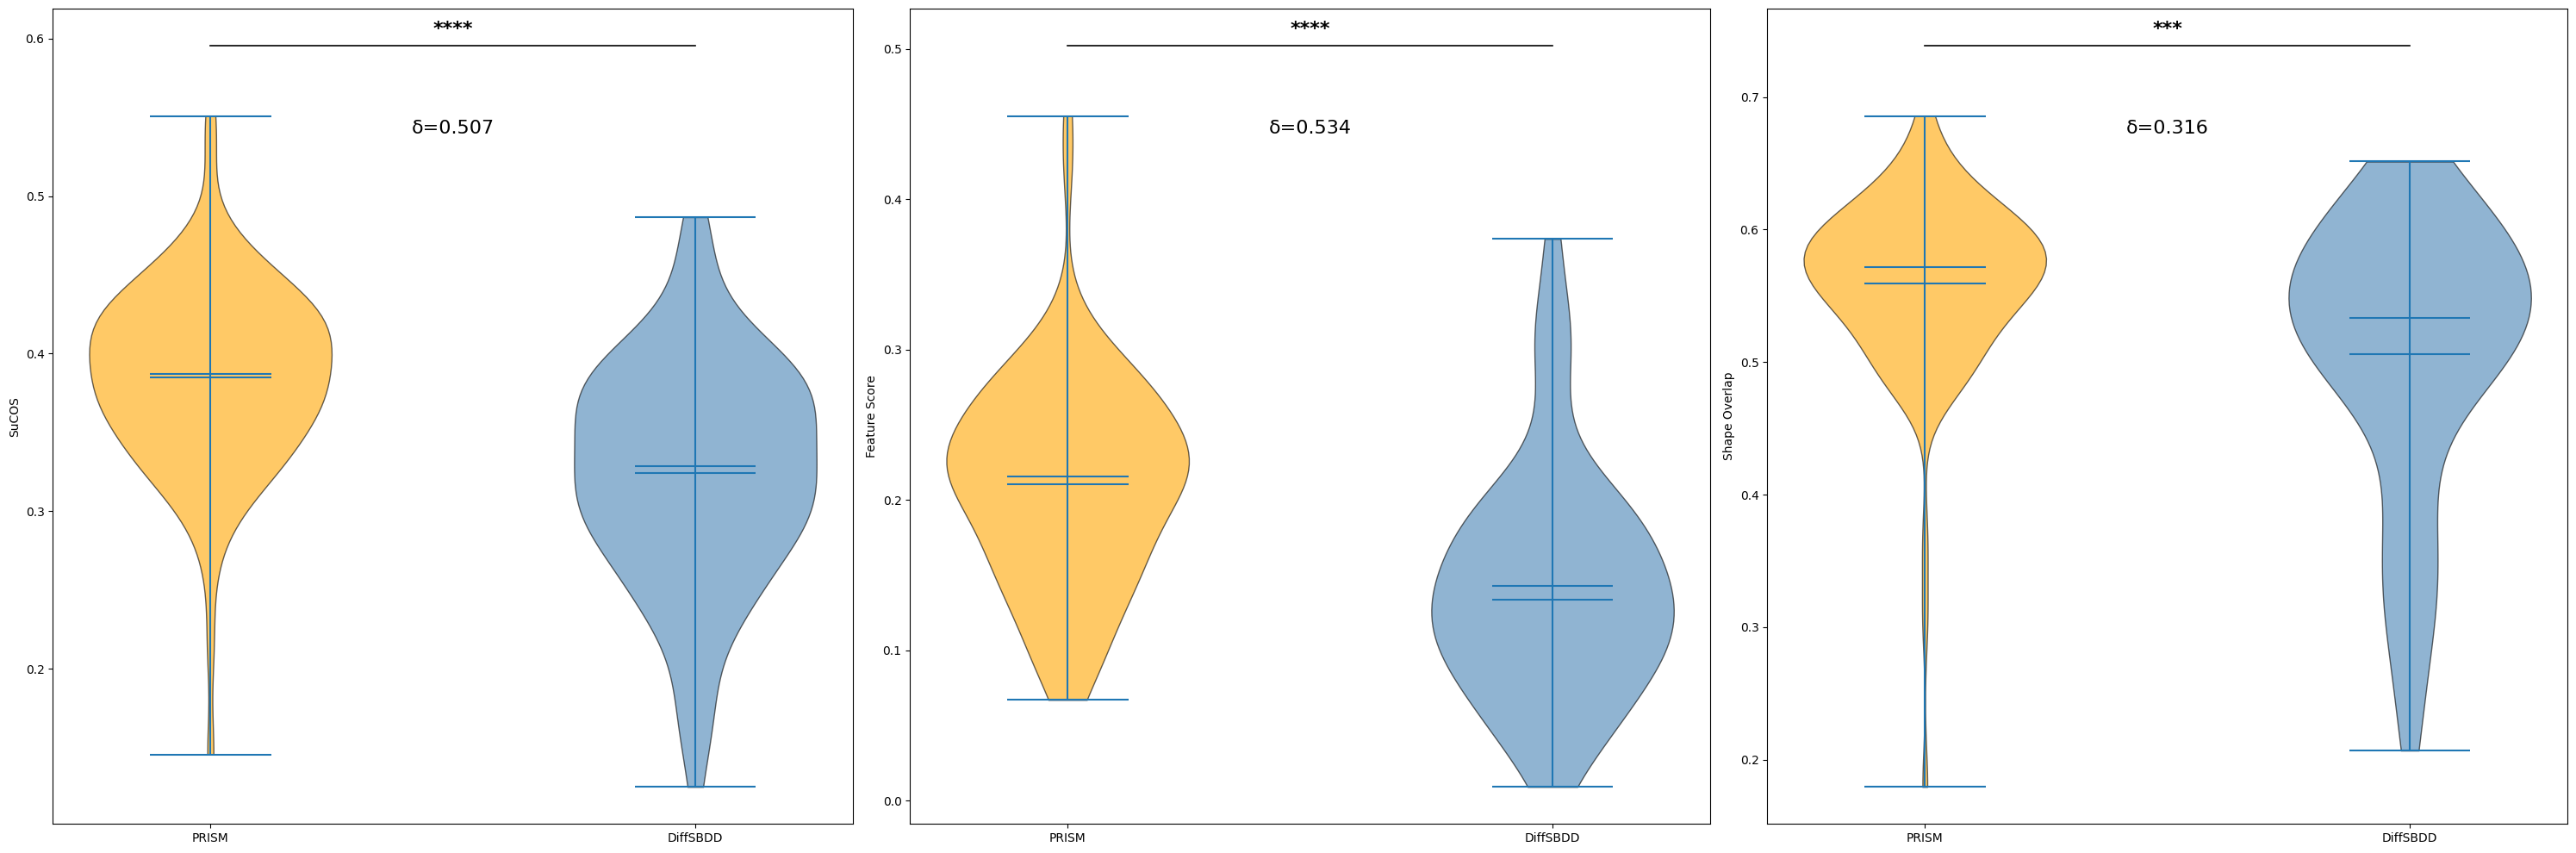

In [13]:
# ---------- Make plots ----------
fig, axes = plt.subplots(1, 3, figsize=(30,10))

violin(axes[0],
       [sucos_prism, sucos_diff],
       ["PRISM","DiffSBDD"],
       "SuCOS", *results["SuCOS"])

violin(axes[1],
       [feat_prism, feat_diff],
       ["PRISM","DiffSBDD"],
       "Feature Score", *results["Feature Score"])

violin(axes[2],
       [shape_prism, shape_diff],
       ["PRISM","DiffSBDD"],
       "Shape Overlap", *results["Shape Overlap"])

plt.tight_layout()
plt.show()



=== SuCOS: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7386, p=7.03e-10
Cliff's δ=0.507 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Features: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7515, p=8.85e-11
Cliff's δ=0.534 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Shape: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=6450, p=0.000121
Cliff's δ=0.316 (|δ|≈0.147 small, 0.33 medium, 0.474 large)


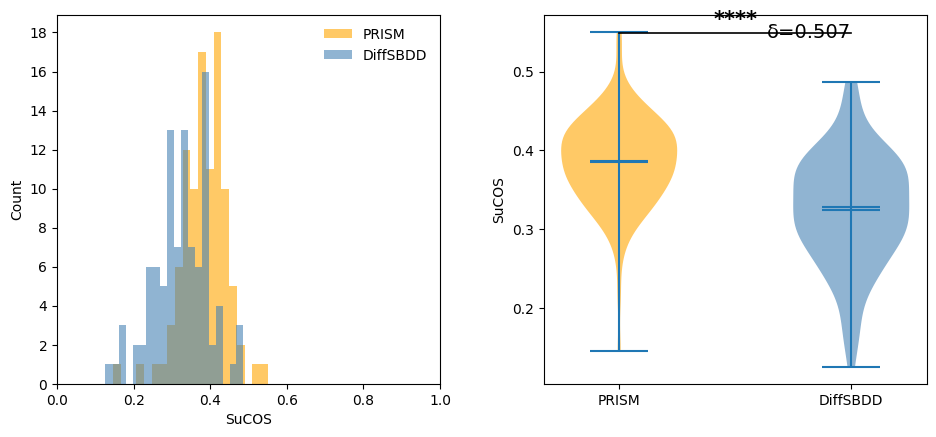

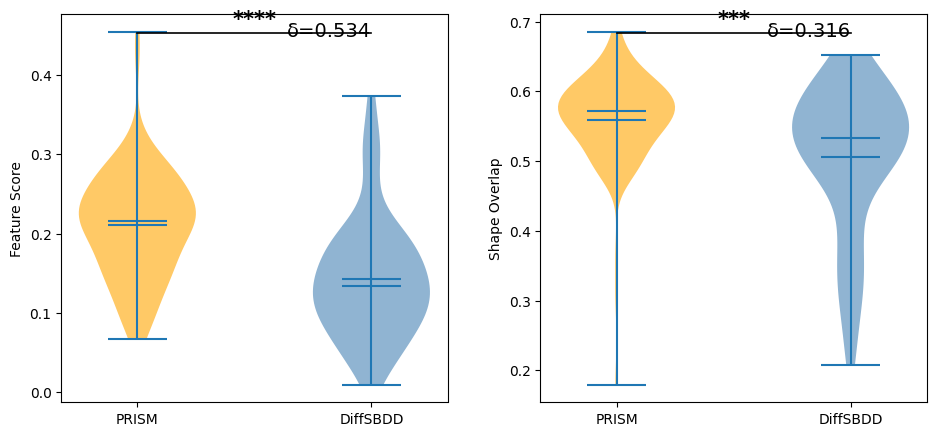

In [33]:
# sucos_analysis_notebook.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import matplotlib.ticker as mticker


# ---------- Load CSV ----------
csv_path = "/Users/sanazkazeminia/Documents/mol_test_suite/data/similarity_experiments/sucos_sim/sucos_comparison_7e2z_diffsbdd_prism.csv"
df = pd.read_csv(csv_path)

COLOR_PRISM = "orange"
COLOR_DIFF  = "steelblue"

# ---------- Helpers ----------
def _as_clean_array(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x)]

def cliffs_delta(x, y):
    x = _as_clean_array(x); y = _as_clean_array(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0: return np.nan
    if nx * ny <= 100000:
        diff = x[:, None] - y[None, :]
        return (np.sum(diff > 0) - np.sum(diff < 0)) / (nx * ny)
    rng = np.random.default_rng(123)
    xs = rng.choice(x, size=min(nx, 500), replace=False)
    ys = rng.choice(y, size=min(ny, 500), replace=False)
    diff = xs[:, None] - ys[None, :]
    return (np.sum(diff > 0) - np.sum(diff < 0)) / (xs.size * ys.size)

def run_stats(x, y, label):
    print(f"\n=== {label}: PRISM vs DiffSBDD ===")
    x = _as_clean_array(x); y = _as_clean_array(y)
    print(f"n_PRISM={len(x)}, n_DiffSBDD={len(y)}")
    u = mannwhitneyu(x, y, alternative="two-sided")
    delta = cliffs_delta(x, y)
    print(f"Mann–Whitney U: U={u.statistic:.4g}, p={u.pvalue:.3g}")
    print(f"Cliff's δ={delta:.3f} (|δ|≈0.147 small, 0.33 medium, 0.474 large)")
    return u.pvalue, delta

def p_to_stars(p):
    if p <= 0.0001: return "****"
    elif p <= 0.001: return "***"
    elif p <= 0.01: return "**"
    elif p <= 0.05: return "*"
    else: return "ns"

def violin(ax, data, labels, ylabel, pval=None, delta=None):
    parts = ax.violinplot(data, showmeans=True, showmedians=True)
    for pc, color in zip(parts['bodies'], [COLOR_PRISM, COLOR_DIFF]):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)


    if pval is not None:
        ymin, ymax = ax.get_ylim()
        y_star = ymax - 0.05*(ymax-ymin)
        ax.plot([1,2],[y_star,y_star], color="black", lw=1.2)
        ax.text(1.5, y_star+0.01*(ymax-ymin), p_to_stars(pval),
                ha="center", va="bottom", fontsize=15, weight="bold")
        if delta is not None:
            ax.text(
                2.0,                         # x-position (right violin)
                ymax - 0.02*(ymax - ymin),   # y-position, slightly below the top
                f"δ={delta:.3f}",
                ha="right", va="top",
                fontsize=14                  # tweak size here
            )

def two_hist(ax, prism_vals, diff_vals, xlabel, bins=20):
    ax.hist(prism_vals, bins=bins, alpha=0.6, color=COLOR_PRISM, label="PRISM")
    ax.hist(diff_vals,  bins=bins, alpha=0.6, color=COLOR_DIFF,  label="DiffSBDD")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.legend(frameon=False)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.set_xlim(0, 1)


# ---------- Split ----------
sucos_prism  = df[df["set"]=="PRISM"]["sucos"].dropna().values
sucos_diff   = df[df["set"]=="DiffSBDD"]["sucos"].dropna().values

feat_prism   = df[df["set"]=="PRISM"]["features"].dropna().values
feat_diff    = df[df["set"]=="DiffSBDD"]["features"].dropna().values

shape_prism  = df[df["set"]=="PRISM"]["shape"].dropna().values
shape_diff   = df[df["set"]=="DiffSBDD"]["shape"].dropna().values

# ---------- Stats ----------
p_sucos, d_sucos   = run_stats(sucos_prism, sucos_diff, "SuCOS")
p_feat, d_feat     = run_stats(feat_prism, feat_diff, "Features")
p_shape, d_shape   = run_stats(shape_prism, shape_diff, "Shape")

# ---------- Plots ----------
# 1) SuCOS: histogram + violin
fig, axes = plt.subplots(1, 2, figsize=(10,5))
two_hist(axes[0], sucos_prism, sucos_diff, "SuCOS", bins=20)
violin(axes[1], [sucos_prism, sucos_diff], ["PRISM","DiffSBDD"], "SuCOS", p_sucos, d_sucos)
plt.tight_layout(pad=3.0)
plt.show()

# 2) Features + Shape: side-by-side violins
fig, axes = plt.subplots(1, 2, figsize=(10,5))
violin(axes[0], [feat_prism, feat_diff], ["PRISM","DiffSBDD"], "Feature Score", p_feat, d_feat)
violin(axes[1], [shape_prism, shape_diff], ["PRISM","DiffSBDD"], "Shape Overlap", p_shape, d_shape)
plt.tight_layout(pad=3.0)
plt.show()



=== SuCOS: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7386, p=7.03e-10
Cliff's δ=0.507 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Features: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=7515, p=8.85e-11
Cliff's δ=0.534 (|δ|≈0.147 small, 0.33 medium, 0.474 large)

=== Shape: PRISM vs DiffSBDD ===
n_PRISM=100, n_DiffSBDD=98
Mann–Whitney U: U=6450, p=0.000121
Cliff's δ=0.316 (|δ|≈0.147 small, 0.33 medium, 0.474 large)


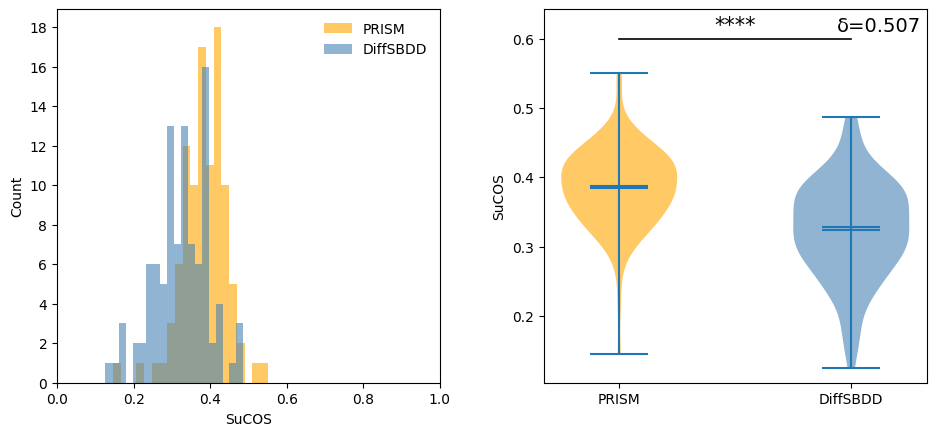

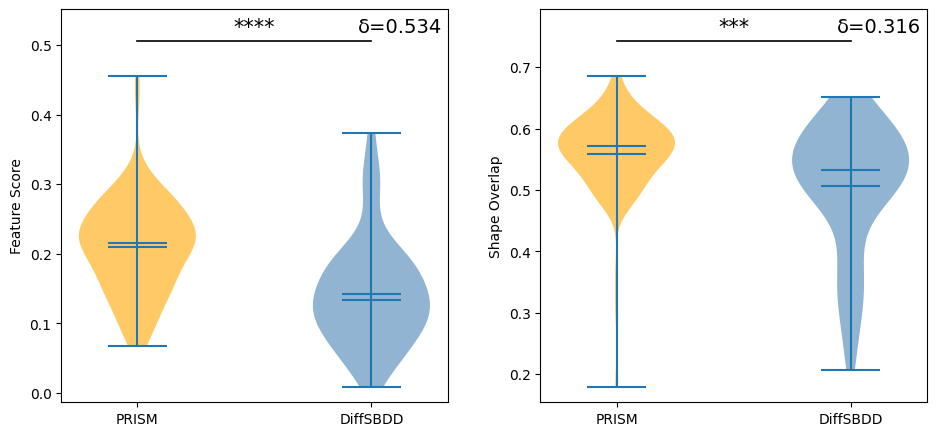

In [ ]:
# sucos_analysis_notebook.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import matplotlib.ticker as mticker


# ---------- Load CSV ----------
csv_path = "/Users/sanazkazeminia/Documents/mol_test_suite/data/similarity_experiments/sucos_sim/sucos_comparison_7e2z_diffsbdd_prism.csv"
df = pd.read_csv(csv_path)

COLOR_PRISM = "orange"
COLOR_DIFF  = "steelblue"

# ---------- Helpers ----------
def _as_clean_array(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x)]

def cliffs_delta(x, y):
    x = _as_clean_array(x); y = _as_clean_array(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0: return np.nan
    if nx * ny <= 100000:
        diff = x[:, None] - y[None, :]
        return (np.sum(diff > 0) - np.sum(diff < 0)) / (nx * ny)
    rng = np.random.default_rng(123)
    xs = rng.choice(x, size=min(nx, 500), replace=False)
    ys = rng.choice(y, size=min(ny, 500), replace=False)
    diff = xs[:, None] - ys[None, :]
    return (np.sum(diff > 0) - np.sum(diff < 0)) / (xs.size * ys.size)

def run_stats(x, y, label):
    print(f"\n=== {label}: PRISM vs DiffSBDD ===")
    x = _as_clean_array(x); y = _as_clean_array(y)
    print(f"n_PRISM={len(x)}, n_DiffSBDD={len(y)}")
    u = mannwhitneyu(x, y, alternative="two-sided")
    delta = cliffs_delta(x, y)
    print(f"Mann–Whitney U: U={u.statistic:.4g}, p={u.pvalue:.3g}")
    print(f"Cliff's δ={delta:.3f} (|δ|≈0.147 small, 0.33 medium, 0.474 large)")
    return u.pvalue, delta

def p_to_stars(p):
    if p <= 0.0001: return "****"
    elif p <= 0.001: return "***"
    elif p <= 0.01: return "**"
    elif p <= 0.05: return "*"
    else: return "ns"

def violin(ax, data, labels, ylabel, pval=None, delta=None):
    parts = ax.violinplot(data, showmeans=True, showmedians=True)
    for pc, color in zip(parts['bodies'], [COLOR_PRISM, COLOR_DIFF]):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)

    # Stars + Cliff's delta
    ymin, ymax = ax.get_ylim()
    if pval is not None:
        ymin, ymax = ax.get_ylim()

        # expand the ylim to add headroom for stars
        ax.set_ylim(ymin, ymax + 0.15*(ymax - ymin))

        # recompute after expanding
        ymin, ymax = ax.get_ylim()

        # place stars above everything
        y_star = ymax - 0.08*(ymax - ymin)
        ax.plot([1, 2], [y_star, y_star], color="black", lw=1.2)
        ax.text(
            1.5,
            y_star + 0.01*(ymax - ymin),
            p_to_stars(pval),
            ha="center", va="bottom",
            fontsize=15
        )

    if delta is not None:
        # top-right corner (over the right violin)
        ax.text(
            2.3,
            ymax - 0.02*(ymax - ymin),
            f"δ={delta:.3f}",
            ha="right", va="top",
            fontsize=14
        )

def two_hist(ax, prism_vals, diff_vals, xlabel, bins=20):
    ax.hist(prism_vals, bins=bins, alpha=0.6, color=COLOR_PRISM, label="PRISM")
    ax.hist(diff_vals,  bins=bins, alpha=0.6, color=COLOR_DIFF,  label="DiffSBDD")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.legend(frameon=False)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.set_xlim(0, 1)


# ---------- Split ----------
sucos_prism  = df[df["set"]=="PRISM"]["sucos"].dropna().values
sucos_diff   = df[df["set"]=="DiffSBDD"]["sucos"].dropna().values

feat_prism   = df[df["set"]=="PRISM"]["features"].dropna().values
feat_diff    = df[df["set"]=="DiffSBDD"]["features"].dropna().values

shape_prism  = df[df["set"]=="PRISM"]["shape"].dropna().values
shape_diff   = df[df["set"]=="DiffSBDD"]["shape"].dropna().values

# ---------- Stats ----------
p_sucos, d_sucos   = run_stats(sucos_prism, sucos_diff, "SuCOS")
p_feat, d_feat     = run_stats(feat_prism, feat_diff, "Features")
p_shape, d_shape   = run_stats(shape_prism, shape_diff, "Shape")

# ---------- Plots ----------
# 1) SuCOS: histogram + violin
fig1, axes = plt.subplots(1, 2, figsize=(10,5))
two_hist(axes[0], sucos_prism, sucos_diff, "SuCOS", bins=20)
violin(axes[1], [sucos_prism, sucos_diff], ["PRISM","DiffSBDD"], "SuCOS", p_sucos, d_sucos)
plt.tight_layout(pad=3.0)
fig1.savefig("/Users/sanazkazeminia/Documents/mol_test_suite/data/similarity_experiments/sucos_sim/figures/sucos_distribution_7e2z_diffsbdd_prism.png", dpi=300, bbox_inches="tight")  # high quality


# 2) Features + Shape: side-by-side violins
fig2, axes = plt.subplots(1, 2, figsize=(10,5))
violin(axes[0], [feat_prism, feat_diff], ["PRISM","DiffSBDD"], "Feature Score", p_feat, d_feat)
violin(axes[1], [shape_prism, shape_diff], ["PRISM","DiffSBDD"], "Shape Overlap", p_shape, d_shape)
plt.tight_layout(pad=3.0)
fig2.savefig("/Users/sanazkazeminia/Documents/mol_test_suite/data/similarity_experiments/sucos_sim/figures/sucos_violins_7e2z_diffsbdd_prism.png", dpi=300, bbox_inches="tight")  # high quality


In [ ]:
plt.savefig("sucos_violin.png", dpi=300, bbox_inches="tight")
